In [ ]:
# install libs
!pip install transformers datasets torch numpy pandas wordninja

     |████████████████████████████████| 3.1 MB 12.3 MB/s 
     |████████████████████████████████| 298 kB 71.4 MB/s 
     |████████████████████████████████| 541 kB 87.0 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 72.8 MB/s 
     |████████████████████████████████| 596 kB 74.7 MB/s 
     |████████████████████████████████| 3.3 MB 59.6 MB/s 
     |████████████████████████████████| 132 kB 96.5 MB/s 
     |████████████████████████████████| 243 kB 69.5 MB/s 
     |████████████████████████████████| 1.1 MB 73.4 MB/s 
     |████████████████████████████████| 192 kB 96.2 MB/s 
     |████████████████████████████████| 271 kB 92.8 MB/s 
     |████████████████████████████████| 160 kB 71.8 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=7f368d47097c0bd1a14d7aa17fa6152a7aad6744cb9a1fb9258e6e58f9bdb97a
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# helper for cleaning text data
def clean(row):
    text = row['cr_text']
    if text != None and len(text) > 0:
        return text.split('Initial / Intake Allegation ')[1].replace('\n', ' ')
    return ''

In [ ]:
data = pd.read_csv('cp5_regress_table.csv')
data['cleaned_text'] = data.apply(lambda row: clean(row), axis=1)

In [ ]:
token_lens = []
maxlen = 0
for txt in data.cleaned_text:
    if txt:
        tokens = tokenizer.encode(txt, add_special_tokens=True)
        token_lens.append(len(tokens))
        maxlen = max(maxlen, len(tokens))

print(f"MAX LENGTH: {maxlen}")

data['token_len'] = token_lens
data = data[data['token_len'] < 512]

MAX LENGTH: 611


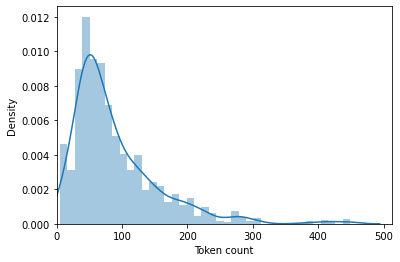

In [ ]:
sns.distplot(data['token_len'])
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [ ]:
import math

from transformers import pipeline
sa = pipeline('sentiment-analysis')

def sentiment_score(txt):
  sentiment = sa(txt)[0]
  negative = sentiment['label'] == 'NEGATIVE'
  score = math.log(1 - sentiment['score'])
  return round(score, 2) * (1 if negative else -1)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
scores = []
for idx, txt in enumerate(data.cleaned_text):
    if txt:
        print(f"{idx}", end=' ')
        if (idx+1) % 10 == 0:
            print("")
        scores.append(sentiment_score(txt))
print("")

0 1 2 3 4 5 6 7 8 9 
10 11 12 13 14 15 16 17 18 19 
20 21 22 23 24 25 26 27 28 29 
30 31 32 33 34 35 36 37 38 39 
40 41 42 43 44 45 46 47 48 49 
50 51 52 53 54 55 56 57 58 59 
60 61 62 63 64 65 66 67 68 69 
70 71 72 73 74 75 76 77 78 79 
80 81 82 83 84 85 86 87 88 89 
90 91 92 93 94 95 96 97 98 99 
100 101 102 103 104 105 106 107 108 109 
110 111 112 113 114 115 116 117 118 119 
120 121 122 123 124 125 126 127 128 129 
130 131 132 133 134 135 136 137 138 139 
140 141 142 143 144 145 146 147 148 149 
150 151 152 153 154 155 156 157 158 159 
160 161 162 163 164 165 166 167 168 169 
170 171 172 173 174 175 176 177 178 179 
180 181 182 183 184 185 186 187 188 189 
190 191 192 193 194 195 196 197 198 199 
200 201 202 203 204 205 206 207 208 209 
210 211 212 213 214 215 216 217 218 219 
220 221 222 223 224 225 226 227 228 229 
230 231 232 233 234 235 236 237 238 239 
240 241 242 243 244 245 246 247 248 249 
250 251 252 253 254 255 256 257 258 259 
260 261 262 263 264 265 266 267 268 269 
270

In [ ]:
data['score'] = scores

In [ ]:
data.to_csv('cp5_data_with_sa_score.csv', index=False)